In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [8]:
def one_hot_encoding(labels):
  labels = pd.factorize(labels)[0]
  one_hot_labels = np.zeros((labels.shape[0],np.max(labels)+1))
  for i,label in enumerate(one_hot_labels):
      label[labels[i]] = 1
  return one_hot_labels


def iris_dataset_uci(df):
  df = pd.read_csv(df,delim_whitespace = False,header=None)
  df = df.values
  train_data = df[:100,:4]
  test_data = df[100:,:4]
  train_labels = one_hot_encoding(df[:100,4])
  test_labels = one_hot_encoding(df[100:,4])
  return (np.array(train_data),np.array(train_labels)),(np.array(test_data),np.array(test_labels))


def balance_dataset_uci(df):
  df = pd.read_csv(df,delim_whitespace = False,header=None)
  train_data = df[:400,1:]
  test_data = df[400:,1:]
  train_labels = one_hot_encoding(df[:400,0])
  test_labels = one_hot_encoding(df[400:,0])
  return (np.array(train_data),np.array(train_labels)),(np.array(test_data),np.array(test_labels))


In [3]:
# Reference: https://ashwins-code.github.io/posts/deep-learning-lib-2/
# Reference: https://github.com/kojino/deep-learning-from-scratch/blob/master/7_back_propagation.ipynb

class feed_forward_mul():
  def front_pass(self, X,Y):
    self.X = np.squeeze(np.array(X,dtype='float'))
    self.Y = np.squeeze(np.array(Y,dtype='float'))
    result = np.matmul(self.X,self.Y)
    return result

  def back_pass(self,dr):
    X = self.X
    Y = self.Y
    dr = np.squeeze(np.array([dr]))
    if len(dr.shape) == 1:
      if len(X.shape) == 2:
        dY = np.kron(Y,dr)
        dY = np.reshape(dY,(Y.shape[0],dr.shape[0]))
      else:
          dY = np.matmul(Y.T,dr)            
      if len(Y.shape) == 2:
          dX = np.kron(X,dr)
          dX = np.reshape(dX,(X.shape[0],dr.shape[0]))
      else:
          dX = np.matmul(X.T,dr)
    else:
        dX = Y*dr
        dY = X*dr
    return [dX, dY]

class feed_forward_add():
  def front_pass(self,X,Y):
        self.X = np.squeeze(np.array(X,dtype=float))
        self.Y = np.squeeze(np.array(Y,dtype=float))
        result = np.add(self.X,self.Y)
        return result
    
  def back_pass(self,dr):
      dX = 1*dr
      dY = 1*dr
      return [dX, dY]

In [4]:
class activation_crossentropy():
  def front_pass(self,Y1,Y2):
    self.Y1 = np.squeeze(np.array(Y1,dtype=float))
    self.Y2 = np.squeeze(np.array(Y2,dtype=float))
    for i,y in enumerate(self.Y1):
      if self.Y2[i] == 1:
          activation = np.log(y)
    return activation

  def back_pass(self):
    dL = (self.Y2 - self.Y1)
    return dL

class activation_softmax():
  def front_pass(self,X):
    self.X = np.squeeze(np.array([X],dtype=float))
    Y = np.zeros(self.X.shape)
    temp = 0
    for x in self.X:
      temp += np.exp(x)
    for i,x in enumerate(self.X):
      Y[i] = np.exp(x)/temp
    self.Y = Y
    return Y

  def back_pass(self, dr):
    Y = self.Y
    D = np.zeros((Y.shape[0],Y.shape[0]),dtype=float)
    for j,y in enumerate(Y):
      for i,x in enumerate(Y):
        if i == j:
          D[i,j] = (y*(1-x))
        else:
          D[i,j] = -y*x
    dr = np.squeeze(np.array([dr]))
    return np.matmul(D,dr)

class activation_sigmoid():
  def front_pass(self,X):
    self.X = np.squeeze(np.array([X],dtype=float))
    Y = np.zeros((self.X.shape),dtype=float)
    for i,x in enumerate(self.X):
      Y[i] = 1/(1 + np.exp(-x))
      self.Y = Y
      return self.Y
    
  def back_pass(self,dr):
    Y = self.Y
    D = np.zeros((Y.shape[0],Y.shape[0]),dtype=float)
    for j,y in enumerate(Y):
      for i,x in enumerate(Y):
        if i == j:
          D[i,j] = (y*(1-x))
        else:
          D[i,j] = 0
    dZ = np.squeeze(np.array([dr]))
    return np.matmul(D,dr)

In [5]:
class computation_graph():
  def __init__(self,X,Y,node1=2,node2=2,learning_rate=0.01):
    node3=Y.shape[1]
    self.node1 = node1
    self.W1 = np.ones((self.node1,X.shape[1]+1))*learning_rate
    self.feed_forward1 = feed_forward_mul()
    self.addition1 = feed_forward_add()
    self.sigmoid1 = activation_sigmoid()
        
    self.node2 = node2
    self.W2 = np.ones((self.node2,self.node1+1))*learning_rate
    self.feed_forward2 = feed_forward_mul()
    self.addition2 = feed_forward_add()
    self.sigmoid2 = activation_sigmoid()
        
    self.node3 = node3
    self.W3 = np.ones((self.node3,self.node2+1))*learning_rate
    self.feed_forward3 = feed_forward_mul()
    self.addition3 = feed_forward_add()
    self.softmax = activation_softmax()
    self.loss = activation_crossentropy()

  def front_pass(self,X,Y2):
    X = np.array(X)
    Y2 = np.array(Y2)
    W1 = self.W1
    W2 = self.W2
    W3 = self.W3

    WM1 = self.feed_forward1.front_pass(W1[:,1:],X)
    WA1 = self.addition1.front_pass(W1[:,1],WM1)
    WZ1 = self.sigmoid1.front_pass(WA1)

    WM2 = self.feed_forward2.front_pass(W2[:,1:],WZ1)
    WA2 = self.addition2.front_pass(W2[:,1],WM2)
    WZ2 = self.sigmoid2.front_pass(WA2)
    
    WM3 = self.feed_forward3.front_pass(W3[:,1:],WZ2)
    WA3 = self.addition3.front_pass(W3[:,1],WM3)
    WY1 = self.softmax.front_pass(WA3)
    
    loss0 = self.loss.front_pass(WY1,Y2)
    return loss0,WY1

  def back_pass(self):
    WDY1 = self.loss.back_pass()
    WDA3 = self.softmax.back_pass(WDY1)
    WDM3 = self.addition3.back_pass(WDA3)
    WDZ2 = self.feed_forward3.back_pass(WDM3[0])
    
    WDA2 = self.sigmoid2.back_pass(WDZ2[0])
    WDM2 = self.addition2.back_pass(WDA2)
    WDZ1 = self.feed_forward2.back_pass(WDM2[0])
    
    WDA1 = self.sigmoid1.back_pass(WDZ1[0])
    WDM1 = self.addition1.back_pass(WDA1)
    WDW1 = self.feed_forward1.back_pass(WDM1[0])
    
    WDW1 = np.row_stack([WDM1[1],WDW1[1]]).T
    WDW2 = np.row_stack([WDM2[1],WDZ1[1]]).T
    WDW3 = np.row_stack([WDM3[1],WDZ2[1]]).T
    return WDW1,WDW2,WDW3

  def train(self, x_in, y_in, epochs=100, decay_rate=0.01, learning_rate = 0.01):
    loss1 = []
    for x in range(epochs):
        epochLoss = 0
        
        s = np.arange(0,len(x_in),1)
        np.random.shuffle(s)
        
        X = x_in[s]
        Y2 = y_in[s]
        
        for i in range(X.shape[0]):
            sLoss,Y1 = self.front_pass(X[i],Y2[i])
            W1,W2,W3 = self.back_pass()
            alpha = learning_rate * (1/(1 + decay_rate*epochs))
            
            self.W1 = np.add(self.W1,-(learning_rate*W1))
            self.W2 = np.add(self.W2,-(learning_rate*W2))
            self.W3 = np.add(self.W3,-(learning_rate*W3))
            
            epochLoss += sLoss
        epochLoss = (epochLoss/X.shape[0])
        learning_rate = alpha
        loss1.append(epochLoss)
    return loss1

  def test(self,X,Y2):
      acc1 = 0
      for i in range(X.shape[0]):
          _,Y1 = self.front_pass(X[i],Y2[i])
          print("Vector embeddings - {} \t Output Vectors - {}".format(Y1,Y2[i]))
          if (Y2[i,np.argmax(Y1)] ==  np.argmax(Y1)):
              acc1 += 1
      accuracy =  acc1/X.shape[0]
      return accuracy

Vector embeddings - [0.34837935 0.31726725 0.33435341] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.34837907 0.31726753 0.33435339] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.34837895 0.31726766 0.33435339] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.34837916 0.31726744 0.3343534 ] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.34837933 0.31726727 0.33435341] 	 Output Vectors - [0. 0. 1.]
Vector embeddings - [0.34837949 0.3172671  0.33435341] 	 Output Vectors - [0. 0. 1.]
Vector embeddings - [0.34837933 0.31726727 0.33435341] 	 Output Vectors - [0. 0. 1.]
Vector embeddings - [0.3483792 0.3172674 0.3343534] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.34837901 0.3172676  0.33435339] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.34837922 0.31726738 0.3343534 ] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.3483789  0.31726772 0.33435338] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.34837929 0.31726731 0.3343534 ] 	 Output Vect

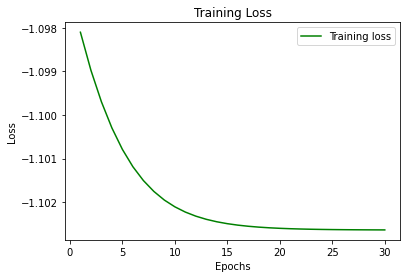

Accuracy:  0.6


In [16]:
(x_train,y_train),(x_test,y_test) = iris_dataset_uci("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

comp_graph = computation_graph(x_train,y_train)
loss = comp_graph.train(x_train,y_train,epochs=30,decay_rate=0.01, learning_rate=0.01)
accuracy = comp_graph.test(x_test,y_test)

loss_values = loss
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'g',label='Training loss')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Accuracy: ",accuracy)

Vector embeddings - [0.03201996 0.93462311 0.03335693] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.03281797 0.9330047  0.03417734] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.03208392 0.93449338 0.0334227 ] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.03222777 0.93420163 0.0335706 ] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.03208542 0.93449035 0.03342423] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.03195607 0.93475269 0.03329124] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.03237977 0.93389337 0.03372687] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.03222736 0.93420246 0.03357018] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.03201728 0.93462856 0.03335417] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.03208494 0.93449132 0.03342374] 	 Output Vectors - [1. 0. 0.]
Vector embeddings - [0.03222369 0.9342099  0.03356641] 	 Output Vectors - [0. 1. 0.]
Vector embeddings - [0.032304   0.93404702 0.03364898] 	 Output V

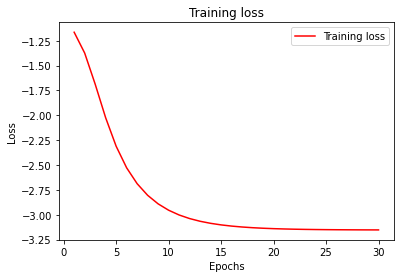

Accuracy: 0.43555555555555553


In [20]:
(x_train,y_train),(x_test,y_test) = balance_dataset_uci("https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data")

comp_graph = computation_graph(x_train,y_train)
loss = comp_graph.train(x_train,y_train,epochs=30,decay_rate=0.01,learning_rate=0.01)
accuracy = comp_graph.test(x_test,y_test)

loss_values = loss
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'r',label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Accuracy:",accuracy)